Code Credit: https://nbviewer.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC3.ipynb

In [18]:
import pymc3 as pm
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
from IPython.core.pylabtools import figsize

### Create an artificial dataset

In [75]:
#Specify when the user behavior switched 
tau = np.random.randint(0, 80)
print(tau)

27


In [80]:
#Draw lambda_1 and lambda_2 (Lambda is a parameter of the poisson distribution - the average texts receieved each day)
alpha = 1./20.
lambda_1, lambda_2 = np.random.exponential(scale=1/alpha, size=2)
print(lambda_1, lambda_2)

28.651611916161492 46.65834513153223


In [81]:
#For days before the change, you sample from Poi(lambda_1) and for days after the change, you sample from Poi(lambda_2)
data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size = 80 - tau)]

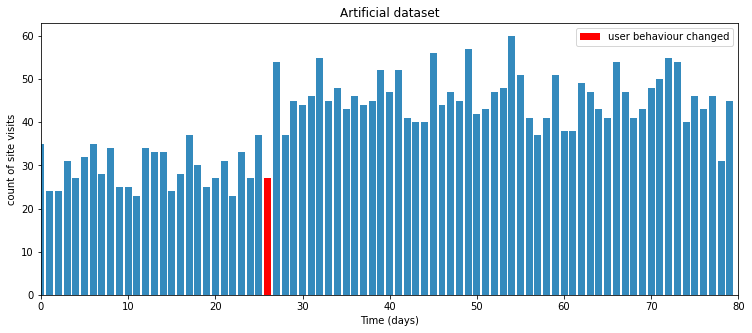

In [82]:
#Plot the artifical data
figsize(12.5, 5)
plt.bar(np.arange(80), data, color="#348ABD")
plt.bar(tau-1, data[tau - 1], color="r", label="user behaviour changed")
plt.xlabel("Time (days)")
plt.ylabel("count of site visits")
plt.title("Artificial dataset")
plt.xlim(0, 80)
plt.legend();

### Modeling this data

How do we start to model this? Count data can be modeled using a poisson distribution. A poisson distrbution has a parameter called lambda which determines how the distribution is spread. Lambda is nothing but the expected count. For e.g., lambda = 4.2 is centered around 4.2, whereas lambda = 1.5 is centered around 1.5.

If lambda is high, there is higher probability assigned to larger values. 

<div>
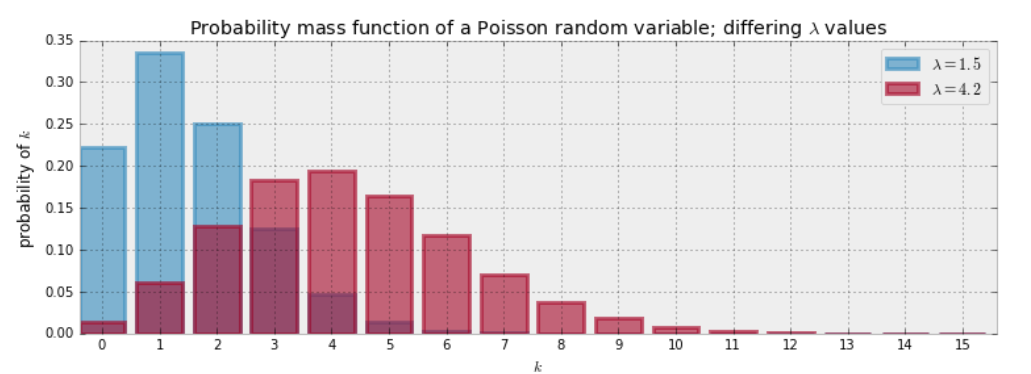
</div>

When we are before the switching period, we use lambda_1, when we are after the switching period we use lambda_2. 

<div>
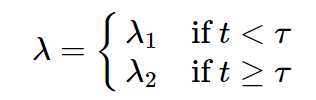
</div>

But lambda itself is an unknown variable. So we model lambda as well. Lambda can only take on positive values. So an exponential distribution is a good option to model lambda because an exponential curve has only positive values.

<div>
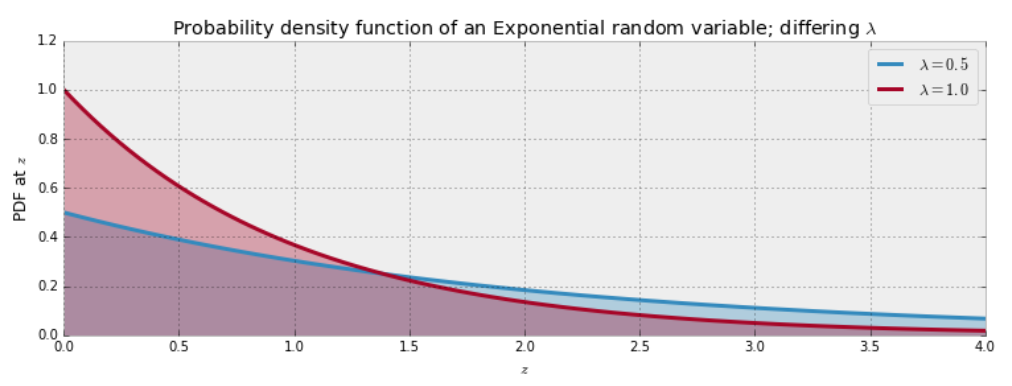
</div>

The exponential distribution has its own lambda parameter, but to avoid confusion, let's call it alpha. So the data that we are trying to model looks as below.

<div>
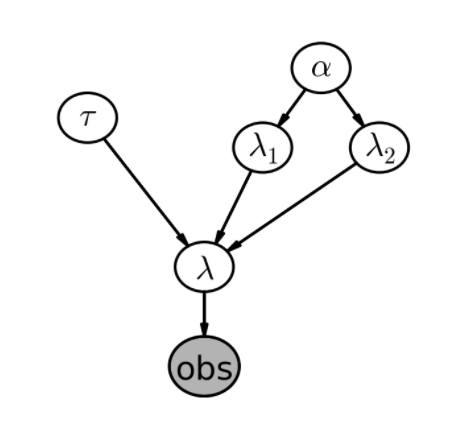
</div>

### Introducing pymc3

In [83]:
import pymc3 as pm

with pm.Model() as model:
    alpha = 1.0/data.mean()  # Recall _data is the variable that holds our website visit counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(data) - 1)

In [84]:
with model:
    idx = np.arange(len(data)) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [85]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=data)

In [86]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 78 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [87]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

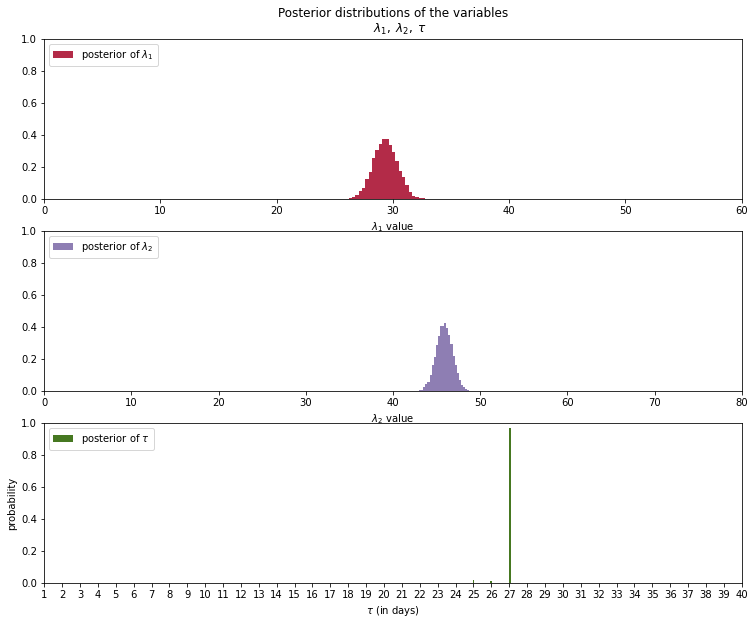

In [103]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([0, 60])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([0, 80])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=len(data), alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(len(data)))

plt.legend(loc="upper left")
plt.ylim([0, 1])
plt.xlim([1, len(data)-40])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

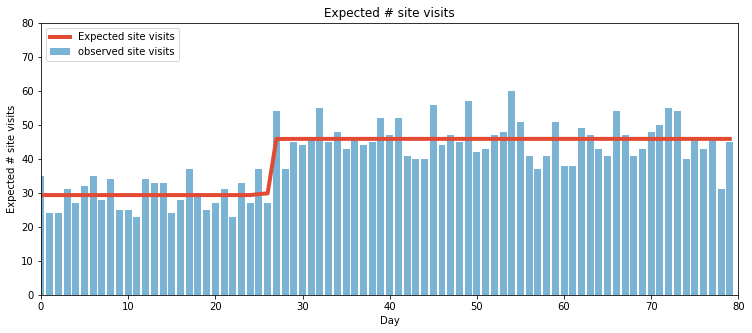

In [98]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(len(data))
for day in range(0, len(data)):
    ix = day < tau_samples
    
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(len(data)), expected_texts_per_day, lw=4, color="#E24A33",
         label="Expected site visits")
plt.xlim(0, len(data))
plt.xlabel("Day")
plt.ylabel("Expected # site visits")
plt.title("Expected # site visits")
plt.ylim(0, 80)
plt.bar(np.arange(len(data)), data, color="#348ABD", alpha=0.65,
        label="observed site visits")

plt.legend(loc="upper left");
